# Homework 2 - EECS 600 Deep Learning

Name: Andrew Tarnoff (art81)

NOTE: I am using loss as Reconstruction Error

Instructions: All assignments are to be completed individually. Please complete each question as best you can. Once you have completed all of the problems, reset your runtime or kernel and run the notebook in order. Download the .ipynb file and submit it via Canvas.

Library usage: Several of the algorithms implemented in this, and other assignments, have implementations available in tensorflow. For this assignment, you are limited to basic operations within tensorflow and cannot use their high level APIs like tf.optimizer, tf.keras, etc.

All code presented in class is free to use in your assignments.

Your grade is based on the correctness of your implementation, not the quality of your code but you are encouraged to include comments in your code to help the graders understand your decisions.

For clarity, the final operation you should take is restarting the runtime and running all.

Due Date: 10/15/19 - midnight EST

100 Points Total

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline
tf.enable_eager_execution()

In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = np.reshape(x_train, (x_train.shape[0], 28*28))
x_test = np.reshape(x_test, (x_test.shape[0], 28*28))
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255. 

y_train_encoded = tf.one_hot(y_train, 10, dtype='float32')
y_test_encoded  = tf.one_hot(y_test, 10, dtype='float32')

## Recommendation
When building and testing your code, work on a smaller subset of the data. [This example](https://stackoverflow.com/questions/14262654/numpy-get-random-set-of-rows-from-2d-array) may help in that.

Additionally, if you are having trouble getting autoencoders to fit with sigmoid hidden units, feel free to change them to ReLU units instead.

# HELPER FUNCTIONS

In [0]:
def Plot_Loss_and_WeightRegularization(trainL, testL, weightReg):
  epoch_count = range(1, len(trainL) + 1)

  plt.figure(1)
  plt.plot(epoch_count, trainL, 'r--')
  plt.plot(epoch_count, testL, 'b-')
  plt.legend(['Training Reconstruction Error', 'Test Reconstruction Error'])
  plt.xlabel('Epoch')
  plt.ylabel('Reconstruction Error')
  plt.show();
  
  if (len(weightReg) > 0):
    plt.figure(2)
    plt.plot(epoch_count, weightReg, 'r--')
    plt.xlabel('Epoch')
    plt.ylabel('Weight Regularization Value')
    plt.show();

def Train_Autoencoder(model, learning_rate, num_epochs, batch_size, plotWeightRegularization):
  train_loss_plot            = []
  test_loss_plot             = []
  weight_regularization_plot = []
  
  train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train_encoded))
  test_dataset  = tf.data.Dataset.from_tensor_slices((x_test,  y_test_encoded))

  for epoch in range(1, num_epochs + 1):
    train_batches = train_dataset.shuffle(100).batch(batch_size)

    for inp, out in train_batches:
        model.train_step(inp, learning_rate)

    train_out = model(x_train)
    test_out  = model(x_test)

    current_train_loss = model.loss(train_out, x_train)
    current_test_loss  = model.loss(test_out,  x_test)

    print(f'Epoch #{epoch}: Train Loss = {current_train_loss:0.4f} : Test Loss = {current_test_loss:0.4f}')

    train_loss_plot.append(current_train_loss)
    test_loss_plot.append(current_test_loss)
    
    if (plotWeightRegularization):
      weight_regularization_plot.append(tf.reduce_mean(tf.abs(model.W1)))
    
  return (train_loss_plot, test_loss_plot, weight_regularization_plot)

def plot2DRepresentation(x_test_2d, y_test):
  #Loop through the final 2D representation (in x_test6), separate it based on desired output, and plot

  #Generate a list of markers and another of colors
  markers = ["," , ","]
  colors = ['r','g','b','c','k','r','g','b','c','k']
  colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', '0.2', '0.4', '0.6']
  x = [[], [], [], [], [], [], [], [], [], []]
  y = [[], [], [], [], [], [], [], [], [], []]

  for i in range(len(x_test_2d)):
    desiredOut = y_test[i]
    x[desiredOut].append(x_test_2d[i, 0].numpy())
    y[desiredOut].append(x_test_2d[i, 1].numpy())

  # Loop through identifiers, color them, plot them, and then delete empty columns
  i = 0
  while (i < len(y)):
    m = markers[(int)(i/5)]
    c = colors[i]
    plt.scatter(x[i],y[i],marker=m, color=c, label=str(i))
    
    if len(y[i]) == 0:
      y = np.delete(y, i)
      x = np.delete(x, i)
      i -= 1
    i += 1
  
  windowInc = 0.0
  minY = np.amin(y)
  maxY = np.amax(y)
  minX = np.amin(x)
  maxX = np.amax(x)
  
  plt.ylim(minY[0] - windowInc, maxY[0] + windowInc)
  plt.xlim(minX[0] - windowInc, maxX[0] + windowInc)
  plt.legend()
  plt.show()
  
def getAccuracy(des_out, act_out_probabilities):  
  predictions = tf.argmax(act_out_probabilities, 1) #Obtains most probable guess from output layer for all inputs
  equality = tf.equal(predictions, des_out) #Boolean array for when the prediction was correct
  return len(np.where(equality)[0]) / len(equality) # Number of TRUE (equal) terms / number of Terms

# Question 1
Implement an autoencoder that encodes MNIST images as a 64 dimensional representation. Your hidden layer should use sigmoid activation functions. Determine an appropriate learning rate and number of epochs to train your model. Use a minibatch size of 128.

In [0]:
class Autoencoder1_1(object):
  def __init__(self, n_input, n_hidden):    
    # W/b between input and hidden layer
    self.W1 = tf.Variable(tf.random_normal([n_input, n_hidden] , mean=0.0, stddev=0.1, dtype=tf.dtypes.float32, seed=None, name='w1'))
    self.b1 = tf.Variable(tf.random_normal([1, n_hidden], mean=0.0, stddev=0.1, dtype=tf.dtypes.float32, seed=None, name='b1'))
    
    # W/b between hidden layer and output
    self.W2 = tf.Variable(tf.random_normal([n_hidden, n_input], mean=0.0, stddev=0.1, dtype=tf.dtypes.float32, seed=None, name='w2'))
    self.b2 = tf.Variable(tf.random_normal([1, n_input],  mean=0.0, stddev=0.1, dtype=tf.dtypes.float32, seed=None, name='b2'))
    
  def __call__(self, x):
    return self.forward(x)

  def encode(self, x):
    a1 = tf.nn.relu(tf.linalg.matmul(x, self.W1) + self.b1)
    return a1
  
  def decode(self, h):
    a2 = tf.nn.sigmoid(tf.linalg.matmul(h, self.W2) + self.b2)
    return a2

  def forward(self, x):
    a1 = self.encode(x)
    a2 = self.decode(a1)
    return a2
  
  #Uses stochastic gradient descent
  def train_step(self, inputs, learning_rate):
    with tf.GradientTape() as t:
      current_loss = self.loss(self(inputs), inputs)
      dW1, dW2, db1, db2 = t.gradient(current_loss, [self.W1, self.W2, self.b1, self.b2])

    self.W1.assign_sub(learning_rate * dW1)
    self.W2.assign_sub(learning_rate * dW2)
    self.b1.assign_sub(learning_rate * db1)
    self.b2.assign_sub(learning_rate * db2)
    
  def loss(self, y_hat, y):
    return tf.reduce_mean(tf.square(y_hat - y))

In [5]:
# Initialize the model and start training
model_1_1 = Autoencoder1_1(n_input=784, n_hidden=64)

learning_rate = 0.8 #Not sure why this is so high but this yielded good results
num_epochs    = 100
batch_size    = 128

train_loss_plot_1_1, test_loss_plot_1_1, weight_regularization_plot_1_1 = Train_Autoencoder(model_1_1, learning_rate, num_epochs, batch_size, False)

Epoch #1: Train Loss = 0.0696 : Test Loss = 0.0696
Epoch #2: Train Loss = 0.0644 : Test Loss = 0.0644
Epoch #3: Train Loss = 0.0587 : Test Loss = 0.0586
Epoch #4: Train Loss = 0.0531 : Test Loss = 0.0528
Epoch #5: Train Loss = 0.0485 : Test Loss = 0.0482
Epoch #6: Train Loss = 0.0450 : Test Loss = 0.0447
Epoch #7: Train Loss = 0.0423 : Test Loss = 0.0419
Epoch #8: Train Loss = 0.0400 : Test Loss = 0.0396
Epoch #9: Train Loss = 0.0381 : Test Loss = 0.0377
Epoch #10: Train Loss = 0.0364 : Test Loss = 0.0360
Epoch #11: Train Loss = 0.0349 : Test Loss = 0.0345
Epoch #12: Train Loss = 0.0336 : Test Loss = 0.0332
Epoch #13: Train Loss = 0.0324 : Test Loss = 0.0320
Epoch #14: Train Loss = 0.0313 : Test Loss = 0.0309
Epoch #15: Train Loss = 0.0303 : Test Loss = 0.0299
Epoch #16: Train Loss = 0.0294 : Test Loss = 0.0290
Epoch #17: Train Loss = 0.0286 : Test Loss = 0.0282
Epoch #18: Train Loss = 0.0278 : Test Loss = 0.0274
Epoch #19: Train Loss = 0.0270 : Test Loss = 0.0266
Epoch #20: Train Loss

Plot the training and testing reconstruction error for each epoch for your chosed number of epochs and learning rate using matplotlib.

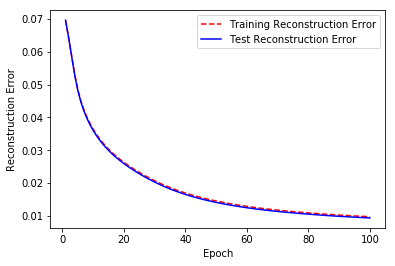

In [6]:
Plot_Loss_and_WeightRegularization(train_loss_plot_1_1, test_loss_plot_1_1, weight_regularization_plot_1_1)

Plot a 10x10 image of reconstructred random examples from your testing set.

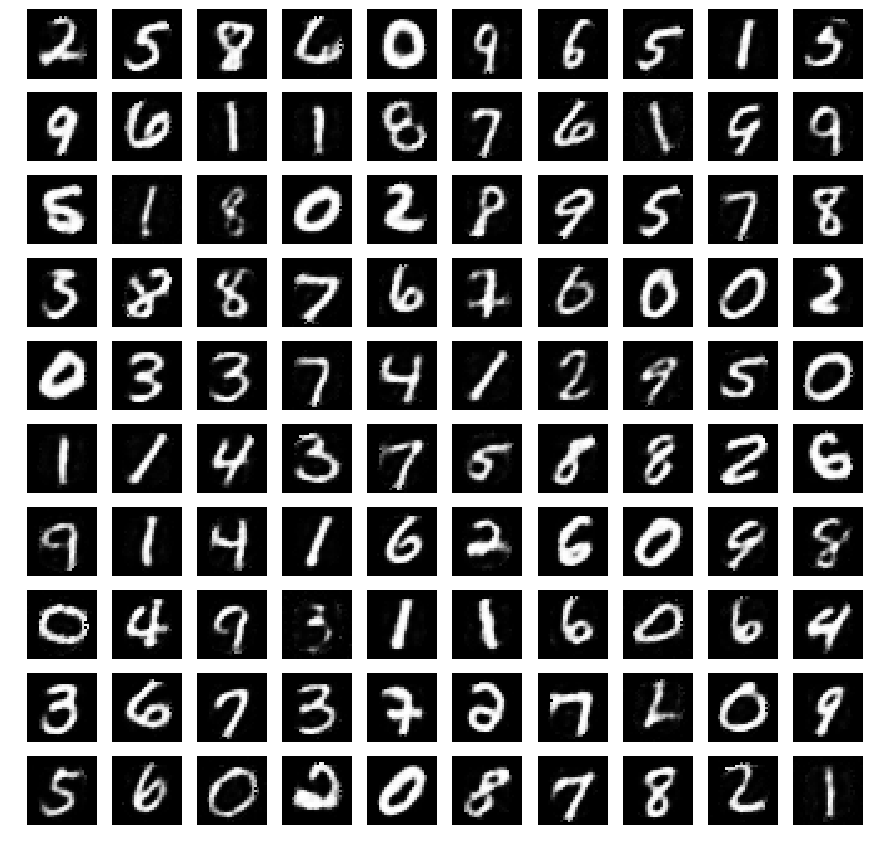

In [7]:
def plotRandomReconstructedTestInput(model, numRows, numCols):
  output = model(x_test)
  
  figure, axes = plt.subplots(nrows=numRows, ncols=numCols)
  figure.set_size_inches(15, 15)
  
  for idx, axis in enumerate(axes.flat):
    idx = random.randint(0,len(x_test))
    
    #originalImage = np.reshape(x_test[idx,:], (28, 28))
    reconstrImage = np.reshape(output[idx,:], (28, 28))
    
    axis.imshow(reconstrImage, cmap=plt.cm.gray)
    axis.set_frame_on(False)
    axis.set_axis_off()
  
plotRandomReconstructedTestInput(model_1_1 , 10, 10)

How did you determine the appropriate learning rate and number of epochs for training?

**In order to determine a good learning rate for this model, I first started at 0.5 (since this is what I used in the previous assignment) and, based on results from a smaller dataset to decrease runtime, adjusted the learning rate until I was satisfied with the results (reproduced input is recognizable). This resulted in raising the learning rate to 0.8. Im not sure why this was so high but compared to lower learning rates such as 0.1, and 0.2 the results were much better and the reproduced inputs were much more recognizable.**

**As for the number of epochs, it was a similar process starting at 50 and ended up increasing it to 100 since this yielded better results and also had the loss plot levelling out sufficiently whereas at 50 epochs it looked like the loss was still going down and further training should be done.**

## Question 1 Part 2
Add an $L_1$ regularization weight term to your loss function only on the weights to your encoder. Your new loss function should be $L(X) = \sum_i(X_i - decode(encode(X_i)))^2 + \alpha\sum_j|W_j|$ where $X$ is a minibatch of your data. Determine an appropriate value of $\alpha$. If you are having trouble getting started, consider values in powers of 10, i.e. $\alpha = 10^-5, 10^-4, 10^-3, ..., 10^1, 10^2, 10^3$.

In [0]:
class Autoencoder1_2(object):
  def __init__(self, n_input, n_hidden, alpha):    
    # W/b between input and hidden layer
    self.W1 = tf.Variable(tf.random_normal([n_input, n_hidden] , mean=0.0, stddev=0.1, dtype=tf.dtypes.float32, seed=None, name='w1'))
    self.b1 = tf.Variable(tf.random_normal([1, n_hidden], mean=0.0, stddev=0.1, dtype=tf.dtypes.float32, seed=None, name='b1'))
    
    # W/b between hidden layer and output
    self.W2 = tf.Variable(tf.random_normal([n_hidden, n_input], mean=0.0, stddev=0.1, dtype=tf.dtypes.float32, seed=None, name='w2'))
    self.b2 = tf.Variable(tf.random_normal([1, n_input],  mean=0.0, stddev=0.1, dtype=tf.dtypes.float32, seed=None, name='b2'))
    
    # Value for L1 regularization
    self.alpha = alpha
    
  def __call__(self, x):
    return self.forward(x)

  def encode(self, x):
    a1 = tf.nn.relu(tf.linalg.matmul(x, self.W1) + self.b1)
    return a1
  
  def decode(self, h):
    a2 = tf.nn.sigmoid(tf.linalg.matmul(h, self.W2) + self.b2)
    return a2

  def forward(self, x):
    a1 = self.encode(x)
    a2 = self.decode(a1)
    return a2
  
  #Uses stochastic gradient descent
  def train_step(self, inputs, learning_rate):
    with tf.GradientTape() as t:
      current_loss = self.loss(self(inputs), inputs)
      dW1, dW2, db1, db2 = t.gradient(current_loss, [self.W1, self.W2, self.b1, self.b2])

    self.W1.assign_sub(learning_rate * dW1)
    self.W2.assign_sub(learning_rate * dW2)
    self.b1.assign_sub(learning_rate * db1)
    self.b2.assign_sub(learning_rate * db2)
    
  def loss(self, y_hat, y):
    return tf.reduce_mean(tf.square(y_hat - y)) + (self.alpha*tf.reduce_mean(tf.abs(self.W1)))

In [9]:
# Initialize the model and start training
model_1_2 = Autoencoder1_2(n_input=784, n_hidden=64, alpha=pow(10,1))

learning_rate = 0.5
num_epochs    = 50 #Sufficient for seeing levelling out of the loss plots for this case. 100 epochs was overkill and took much longer
batch_size    = 128

train_loss_plot_1_2, test_loss_plot_1_2, weight_regularization_plot_1_2 = Train_Autoencoder(model_1_2, learning_rate, num_epochs, batch_size, True)

Epoch #1: Train Loss = 0.5008 : Test Loss = 0.5007
Epoch #2: Train Loss = 0.2709 : Test Loss = 0.2709
Epoch #3: Train Loss = 0.1556 : Test Loss = 0.1555
Epoch #4: Train Loss = 0.1057 : Test Loss = 0.1057
Epoch #5: Train Loss = 0.0869 : Test Loss = 0.0869
Epoch #6: Train Loss = 0.0796 : Test Loss = 0.0797
Epoch #7: Train Loss = 0.0763 : Test Loss = 0.0763
Epoch #8: Train Loss = 0.0743 : Test Loss = 0.0743
Epoch #9: Train Loss = 0.0728 : Test Loss = 0.0729
Epoch #10: Train Loss = 0.0717 : Test Loss = 0.0717
Epoch #11: Train Loss = 0.0707 : Test Loss = 0.0708
Epoch #12: Train Loss = 0.0699 : Test Loss = 0.0699
Epoch #13: Train Loss = 0.0691 : Test Loss = 0.0692
Epoch #14: Train Loss = 0.0685 : Test Loss = 0.0685
Epoch #15: Train Loss = 0.0678 : Test Loss = 0.0679
Epoch #16: Train Loss = 0.0672 : Test Loss = 0.0673
Epoch #17: Train Loss = 0.0666 : Test Loss = 0.0666
Epoch #18: Train Loss = 0.0661 : Test Loss = 0.0661
Epoch #19: Train Loss = 0.0655 : Test Loss = 0.0655
Epoch #20: Train Loss

Plot the training and testing reconstruction error for each epoch for your chosed number of epochs and learning rate using matplotlib. Additionally, plot the weight regularization value at each epoch ($\sum_j|W_j|$).

---



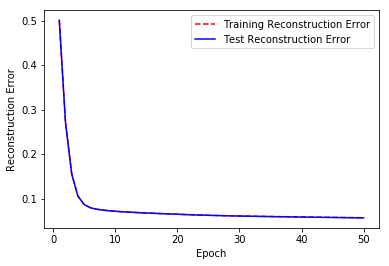

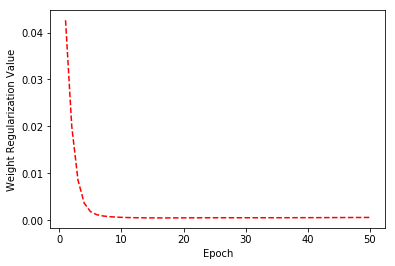

In [10]:
Plot_Loss_and_WeightRegularization(train_loss_plot_1_2, test_loss_plot_1_2, weight_regularization_plot_1_2)

How did you determine the appropriate weight regularization parameter?

**As suggested in the problem statement, I first started with 10^-5 and increased this value by factors of 10 until the results starting getting worse and at that point I settled on a value. For this case I settled on 10^1 since the weight regularization dropped across epochs as expected.**

##Question 2 Part 1
One of the [first papers](https://www.cs.toronto.edu/~hinton/science.pdf) in the deep learning literature proposed greedy layer wise training of deep neural networks. A greedy deep autoencoder first trains the first autoencoder, uses the representation to train the second autoencoder, etc. Train a greedy deep network for the MNIST data with the following layer sizes 400 - 200 - 50 - 10 - 2. Train on a random sample of 20000 MNIST rows. Use sigmoid activation layers and determine an appropriate learning rate.

In [0]:
class Autoencoder2_1(object):
  def __init__(self, n_input, n_hidden):    
    # W/b between input and hidden layer
    self.W1 = tf.Variable(tf.random_normal([n_input, n_hidden] , mean=0.0, stddev=0.1, dtype=tf.dtypes.float32, seed=None, name='w1'))
    self.b1 = tf.Variable(tf.random_normal([1, n_hidden], mean=0.0, stddev=0.1, dtype=tf.dtypes.float32, seed=None, name='b1'))
    
    # W/b between hidden layer and output
    self.W2 = tf.Variable(tf.random_normal([n_hidden, n_input], mean=0.0, stddev=0.1, dtype=tf.dtypes.float32, seed=None, name='w2'))
    self.b2 = tf.Variable(tf.random_normal([1, n_input],  mean=0.0, stddev=0.1, dtype=tf.dtypes.float32, seed=None, name='b2'))
    
  def __call__(self, x):
    return self.forward(x)

  def encode(self, x):
    a1 = tf.nn.sigmoid(tf.linalg.matmul(x, self.W1) + self.b1)
    return a1
  
  def decode(self, h):
    a2 = tf.nn.sigmoid(tf.linalg.matmul(h, self.W2) + self.b2)
    return a2

  def forward(self, x):
    a1 = self.encode(x)
    a2 = self.decode(a1)
    return a2
  
  #Uses stochastic gradient descent
  def train_step(self, inputs, learning_rate):
    with tf.GradientTape() as t:
      current_loss = self.loss(self(inputs), inputs)
      dW1, dW2, db1, db2 = t.gradient(current_loss, [self.W1, self.W2, self.b1, self.b2])

    self.W1.assign_sub(learning_rate * dW1)
    self.W2.assign_sub(learning_rate * dW2)
    self.b1.assign_sub(learning_rate * db1)
    self.b2.assign_sub(learning_rate * db2)
    
  def loss(self, y_hat, y):
    return tf.reduce_mean(tf.square(y_hat - y))

In [0]:
def Train_Autoencoder_with_data(model, learning_rate, num_epochs, batch_size, x_train):
  train_loss_plot = []
  
  train_dataset = tf.data.Dataset.from_tensor_slices((x_train, x_train))

  for epoch in range(1, num_epochs + 1):
    train_batches = train_dataset.shuffle(100).batch(batch_size)

    for inp, out in train_batches:
        model.train_step(inp, learning_rate)

    train_out = model(x_train)

    current_train_loss = model.loss(train_out, x_train)

    print(f'Epoch #{epoch}: Train Loss = {current_train_loss:0.4f}')

    train_loss_plot.append(current_train_loss)
    
  return (train_loss_plot)

In [13]:
# Lets first train all of our autoencoders and we need:
# 1. 784->400->784
# 2. 400->200->400
# 3. 200->50 ->200
# 4. 50 ->10 ->50
# 5. 10 ->2  ->10
indices = random.sample(range(0, len(x_train)), 20000) #Gives 20,000 unique indices
x_train_new = x_train[indices, :] #Train data is 20,000 random samples of MNIST dataset

# Initialize the autoencoders
ac_2_1_1 = Autoencoder2_1(n_input=784, n_hidden=400)
ac_2_1_2 = Autoencoder2_1(n_input=400, n_hidden=200)
ac_2_1_3 = Autoencoder2_1(n_input=200, n_hidden=50)
ac_2_1_4 = Autoencoder2_1(n_input=50,  n_hidden=10)
ac_2_1_5 = Autoencoder2_1(n_input=10,  n_hidden=2)

learning_rate = 0.8 #Again, not sure why this is so high but yielded good results and got here through experimentation
num_epochs    = 100
batch_size    = 128

Train_Autoencoder_with_data(ac_2_1_1, learning_rate, num_epochs, batch_size, x_train_new)
x_train2 = ac_2_1_1.encode(x_train_new)

Train_Autoencoder_with_data(ac_2_1_2, learning_rate, num_epochs, batch_size, x_train2)
x_train3 = ac_2_1_2.encode(x_train2)

Train_Autoencoder_with_data(ac_2_1_3, learning_rate, num_epochs, batch_size, x_train3)
x_train4 = ac_2_1_3.encode(x_train3)

Train_Autoencoder_with_data(ac_2_1_4, learning_rate, num_epochs, batch_size, x_train4)
x_train5 = ac_2_1_4.encode(x_train4)

Train_Autoencoder_with_data(ac_2_1_5, learning_rate, num_epochs, batch_size, x_train5)
x_train6 = ac_2_1_5.encode(x_train5)

Epoch #1: Train Loss = 0.0821
Epoch #2: Train Loss = 0.0713
Epoch #3: Train Loss = 0.0684
Epoch #4: Train Loss = 0.0668
Epoch #5: Train Loss = 0.0655
Epoch #6: Train Loss = 0.0643
Epoch #7: Train Loss = 0.0633
Epoch #8: Train Loss = 0.0623
Epoch #9: Train Loss = 0.0614
Epoch #10: Train Loss = 0.0605
Epoch #11: Train Loss = 0.0596
Epoch #12: Train Loss = 0.0587
Epoch #13: Train Loss = 0.0578
Epoch #14: Train Loss = 0.0569
Epoch #15: Train Loss = 0.0561
Epoch #16: Train Loss = 0.0553
Epoch #17: Train Loss = 0.0544
Epoch #18: Train Loss = 0.0536
Epoch #19: Train Loss = 0.0528
Epoch #20: Train Loss = 0.0521
Epoch #21: Train Loss = 0.0513
Epoch #22: Train Loss = 0.0506
Epoch #23: Train Loss = 0.0499
Epoch #24: Train Loss = 0.0492
Epoch #25: Train Loss = 0.0486
Epoch #26: Train Loss = 0.0479
Epoch #27: Train Loss = 0.0473
Epoch #28: Train Loss = 0.0467
Epoch #29: Train Loss = 0.0461
Epoch #30: Train Loss = 0.0455
Epoch #31: Train Loss = 0.0450
Epoch #32: Train Loss = 0.0445
Epoch #33: Train 

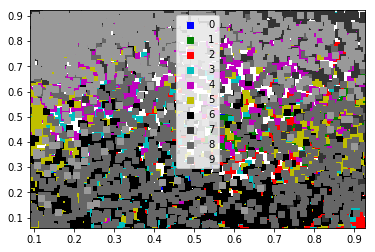

In [14]:
#Run through the encoding process for the test data
x_test2 = ac_2_1_1.encode(x_test)
x_test3 = ac_2_1_2.encode(x_test2)
x_test4 = ac_2_1_3.encode(x_test3)
x_test5 = ac_2_1_4.encode(x_test4)
x_test6 = ac_2_1_5.encode(x_test5)

plot2DRepresentation(x_test6, y_test)

Plot the two dimensional representation and the associated labels for the numbers for the testing data. See figure 3B in the above paper for an example.

## Question 2 Part 2
Instead of training a multi-layer deep architecture, train just one layer of size 2. Once again use sigmoid activation functions and determine an appropriate learning rate.

In [15]:
# Initialize the autoencoder

ac_2_2 = Autoencoder2_1(n_input=784, n_hidden=2)

learning_rate = 0.3
num_epochs    = 100
batch_size    = 128

# Train the autoencoder
loss_plot = Train_Autoencoder_with_data(ac_2_2, learning_rate, num_epochs, batch_size, x_train_new)

Epoch #1: Train Loss = 0.2284
Epoch #2: Train Loss = 0.2249
Epoch #3: Train Loss = 0.2208
Epoch #4: Train Loss = 0.2162
Epoch #5: Train Loss = 0.2111
Epoch #6: Train Loss = 0.2054
Epoch #7: Train Loss = 0.1997
Epoch #8: Train Loss = 0.1941
Epoch #9: Train Loss = 0.1888
Epoch #10: Train Loss = 0.1837
Epoch #11: Train Loss = 0.1789
Epoch #12: Train Loss = 0.1743
Epoch #13: Train Loss = 0.1699
Epoch #14: Train Loss = 0.1657
Epoch #15: Train Loss = 0.1618
Epoch #16: Train Loss = 0.1581
Epoch #17: Train Loss = 0.1546
Epoch #18: Train Loss = 0.1512
Epoch #19: Train Loss = 0.1480
Epoch #20: Train Loss = 0.1450
Epoch #21: Train Loss = 0.1422
Epoch #22: Train Loss = 0.1395
Epoch #23: Train Loss = 0.1369
Epoch #24: Train Loss = 0.1344
Epoch #25: Train Loss = 0.1321
Epoch #26: Train Loss = 0.1299
Epoch #27: Train Loss = 0.1278
Epoch #28: Train Loss = 0.1258
Epoch #29: Train Loss = 0.1239
Epoch #30: Train Loss = 0.1221
Epoch #31: Train Loss = 0.1204
Epoch #32: Train Loss = 0.1188
Epoch #33: Train 

Plot the two dimensional representation and the associated labels for the numbers for the testing data. See figure 3B in the above paper for an example.

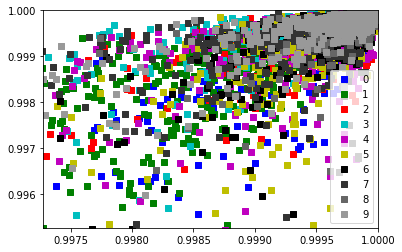

In [16]:
#Run through the encoding process for the test data
x_test_2d = ac_2_2.encode(x_test)

plot2DRepresentation(x_test_2d, y_test)

## Question 2 Part 3
Train a standard feed-forward neural network with one hidden layer of size two and sigmoid activation functions for predicting which digit each of the training samples is from.

In [0]:
class Model_1_layer(object):
  def __init__(self, n_input, n_hidden1, n_output):    
    # W/b between input and hidden layer #1
    self.W1 = tf.Variable(tf.random_normal([n_input, n_hidden1] , mean=0.0, stddev=0.1, dtype=tf.dtypes.float32, seed=None, name='w1'))
    self.b1 = tf.Variable(tf.random_normal([1, n_hidden1], mean=0.0, stddev=0.1, dtype=tf.dtypes.float32, seed=None, name='b1'))
    
    # W/b between hidden layer #1 and output
    self.W2 = tf.Variable(tf.random_normal([n_hidden1, n_output], mean=0.0, stddev=0.1, dtype=tf.dtypes.float32, seed=None, name='w2'))
    self.b2 = tf.Variable(tf.random_normal([1, n_output],  mean=0.0, stddev=0.1, dtype=tf.dtypes.float32, seed=None, name='b2'))
    
  def __call__(self, x):
    return self.forward(x)
  
  def encode(self, x):
    a1 = tf.nn.sigmoid(tf.linalg.matmul(x, self.W1) + self.b1)
    return a1
  
  def decode(self, h):
    a2 = tf.nn.softmax(tf.linalg.matmul(h, self.W2) + self.b2)
    return a2

  def forward(self, x):
    a1 = self.encode(x)
    a2 = self.decode(a1)
    return a2
  
  def loss(self, y_hat, y):
    return tf.reduce_mean(tf.square(y_hat - y))
  
  #Uses stochastic gradient descent
  def train_step(self, inputs, outputs, learning_rate):
    with tf.GradientTape() as t:
      current_loss = self.loss(self(inputs), outputs)
      dW1, dW2, db1, db2 = t.gradient(current_loss, [self.W1, self.W2, self.b1, self.b2])

    self.W1.assign_sub(learning_rate * dW1)
    self.W2.assign_sub(learning_rate * dW2)
    self.b1.assign_sub(learning_rate * db1)
    self.b2.assign_sub(learning_rate * db2)

In [0]:
def Train_Model_1_Layer(model, learning_rate, num_epochs, batch_size):
  train_loss_plot     = []
  test_loss_plot      = []
  train_accuracy_plot = []
  test_accuracy_plot  = []
  
  train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train_encoded))
  test_dataset  = tf.data.Dataset.from_tensor_slices((x_test,  y_test_encoded))

  for epoch in range(1, num_epochs + 1):
    train_batches = train_dataset.shuffle(100).batch(batch_size)

    for inp, out in train_batches:
      if learning_rate < 0:
        model.train_step(inp, out) #Accounts for using AdaDelta
      else:
        model.train_step(inp, out, learning_rate)

    train_out = model(x_train)
    test_out  = model(x_test)

    current_train_loss = model.loss(train_out, y_train_encoded)
    current_test_loss  = model.loss(test_out,  y_test_encoded)
    train_accuracy_percent = getAccuracy(y_train, train_out)*100
    test_accuracy_percent  = getAccuracy(y_test, test_out)*100

    print(f'Epoch #{epoch}: Train Loss = {current_train_loss:0.4f} : Test Loss = {current_test_loss:0.4f} : Train Accuracy = {train_accuracy_percent:0.4f}% : Test Accuracy = {test_accuracy_percent:0.4f}%')

    train_loss_plot.append(current_train_loss)
    test_loss_plot.append(current_test_loss)
    train_accuracy_plot.append(train_accuracy_percent)
    test_accuracy_plot.append(test_accuracy_percent)
    
  return (train_loss_plot, test_loss_plot, train_accuracy_plot, test_accuracy_plot)

In [19]:
# Initialize the model and start training
model_2_3 = Model_1_layer(n_input=784, n_hidden1=2, n_output=10)

learning_rate = 0.9 #This seems really high again but yielded by far the best results...
num_epochs    = 100
batch_size    = 128

train_loss_plot_2_3, test_loss_plot_2_3, train_accuracy_plot_2_3, test_accuracy_plot_2_3 = Train_Model_1_Layer(model_2_3, learning_rate, num_epochs, batch_size)

Epoch #1: Train Loss = 0.0893 : Test Loss = 0.0893 : Train Accuracy = 11.3733% : Test Accuracy = 11.4300%
Epoch #2: Train Loss = 0.0869 : Test Loss = 0.0868 : Train Accuracy = 14.4700% : Test Accuracy = 14.7300%
Epoch #3: Train Loss = 0.0827 : Test Loss = 0.0825 : Train Accuracy = 19.5283% : Test Accuracy = 19.6600%
Epoch #4: Train Loss = 0.0801 : Test Loss = 0.0798 : Train Accuracy = 30.4417% : Test Accuracy = 30.5300%
Epoch #5: Train Loss = 0.0783 : Test Loss = 0.0780 : Train Accuracy = 29.7800% : Test Accuracy = 29.7200%
Epoch #6: Train Loss = 0.0771 : Test Loss = 0.0768 : Train Accuracy = 30.0933% : Test Accuracy = 29.9800%
Epoch #7: Train Loss = 0.0762 : Test Loss = 0.0759 : Train Accuracy = 30.1950% : Test Accuracy = 30.0600%
Epoch #8: Train Loss = 0.0755 : Test Loss = 0.0752 : Train Accuracy = 30.2683% : Test Accuracy = 30.1400%
Epoch #9: Train Loss = 0.0749 : Test Loss = 0.0746 : Train Accuracy = 30.3217% : Test Accuracy = 30.1400%
Epoch #10: Train Loss = 0.0745 : Test Loss = 0

Pot the loss function and accuracy of your model

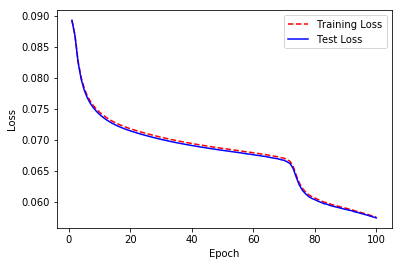

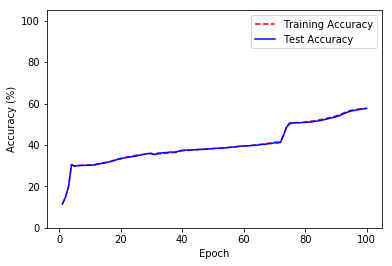

In [20]:
def Plot_Loss_and_Accuracy(trainL, testL, trainA, testA):
  epoch_count = range(1, len(trainL) + 1)

  plt.figure(1)
  plt.plot(epoch_count, trainL, 'r--')
  plt.plot(epoch_count, testL, 'b-')
  plt.legend(['Training Loss', 'Test Loss'])
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.show();

  plt.figure(2)
  plt.plot(epoch_count, trainA, 'r--')
  plt.plot(epoch_count, testA, 'b-')
  plt.legend(['Training Accuracy', 'Test Accuracy'])
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy (%)')
  plt.ylim(0, 105)
  plt.show();
  
Plot_Loss_and_Accuracy(train_loss_plot_2_3, test_loss_plot_2_3, train_accuracy_plot_2_3, test_accuracy_plot_2_3)

Plot the two dimensional representation and the associated labels for the numbers for the testing data. See figure 3B in the above paper for an example.

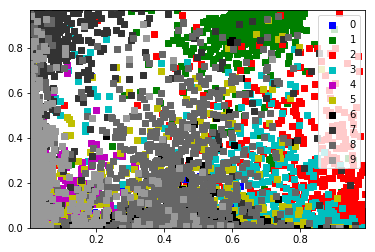

In [21]:
twoD_rep = model_2_3.encode(x_test)

plot2DRepresentation(twoD_rep, y_test)

## Question 2 Part 4
How different are the representations that the different approaches learned? What might make them different?

**From the 3 approaches above it seems that the 2 best are clearly the deep autoencoder and the the simple feed forward network. When referring to "performance" of these approaches I am talking about how separated the 2D plot is based on actual classification. Essentially this means: how well does the 2D representation separate input data where the separation is based on the actual number that was in the inputted drawing.**

**The shallow autoencoder (1 hidden layer of size 2) performs the worst but this makes sense because it is trying to step from 784D to 2D without any knowledge of what the output is. It makes sense that this would be worse than the deep autoencoder since it can't learn as complex features and is more prone to underfitting due to having significantly less layers. Also, it makes sense that it does worse than the simple feed forward network since it doesn't get information on the desired output but is still using a direct 2D representation from the input.**

**As for the 2 best ones, from my experiments it actually seems like the simple feed forward network does the best and separating the data based on the 2D representation. This could make sense, however, since this is the only approach of the three that takes advantage of the labelled data. Since this is incredibly valuable information when separating based on classification (since the classification is given by the labelled data), it allows for this simple network to outperform the more complex deep autoencoder which is working under the assumption that the data is unlabelled. Finally, just an observation about the deep autoencoder is that there are some numbers that it was able to group well and far away from other values but other more similar combnations blend in the representation and are unable to be sufficiently separated.**

# Question 3 Part 1
Build a denoising autoencoder for the MNIST data. On each batch, add random [normal gaussian noise](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.normal.html) to the inputs and then [clip the values](https://docs.scipy.org/doc/numpy/reference/generated/numpy.clip.html) such that they are between 0 and 1. Evaluate the following mean and standard deviation values for the noise.

| Mean  | Standard Deviation |
|-------|--------------------|
| (loc) | (scale)            |
| 0.0   | 0.05               |
| 0.1   | 0.05               |
| 0.0   | 0.2                |
| 0.1   | 0.2                |

Your evaluation should compare the reconstruction error on the testing data with no added error. Use sigmoid activation functions with 64 hidden units.

In [0]:
def addNormalNoise(inputs, mean, std_dev):
  # Loop through all pixels of every input and add random noise to each one
  noise = tf.random_normal(shape=tf.shape(inputs), mean=mean, stddev=std_dev)
  output = inputs + noise
  output_clipped = tf.clip_by_value(output, clip_value_min=0, clip_value_max=1)
  return output_clipped

class Autoencoder_Denoise(object):
  def __init__(self, n_input, n_hidden, mean, std_dev):    
    # W/b between input and hidden layer
    self.W1 = tf.Variable(tf.random_normal([n_input, n_hidden] , mean=0.0, stddev=0.1, dtype=tf.dtypes.float32, seed=None, name='w1'))
    self.b1 = tf.Variable(tf.random_normal([1, n_hidden], mean=0.0, stddev=0.1, dtype=tf.dtypes.float32, seed=None, name='b1'))
    
    # W/b between hidden layer and output
    self.W2 = tf.Variable(tf.random_normal([n_hidden, n_input], mean=0.0, stddev=0.1, dtype=tf.dtypes.float32, seed=None, name='w2'))
    self.b2 = tf.Variable(tf.random_normal([1, n_input],  mean=0.0, stddev=0.1, dtype=tf.dtypes.float32, seed=None, name='b2'))
    
    # Values for random noise
    self.mean = mean
    self.std_dev = std_dev
    
  def __call__(self, x):
    return self.forward(x)

  def encode(self, x):
    a1 = tf.nn.sigmoid(tf.linalg.matmul(x, self.W1) + self.b1)
    return a1
  
  def decode(self, h):
    a2 = tf.nn.sigmoid(tf.linalg.matmul(h, self.W2) + self.b2)
    return a2

  def forward(self, x):
    a1 = self.encode(x)
    a2 = self.decode(a1)
    return a2
  
  #Uses stochastic gradient descent
  def train_step(self, inputs, learning_rate):
    with tf.GradientTape() as t:
      noisyInputs = addNormalNoise(inputs, self.mean, self.std_dev)
      current_loss = self.loss(self(noisyInputs), inputs)
      dW1, dW2, db1, db2 = t.gradient(current_loss, [self.W1, self.W2, self.b1, self.b2])

    self.W1.assign_sub(learning_rate * dW1)
    self.W2.assign_sub(learning_rate * dW2)
    self.b1.assign_sub(learning_rate * db1)
    self.b2.assign_sub(learning_rate * db2)
    
  def loss(self, y_hat, y):
    return tf.reduce_mean(tf.square(y_hat - y))

In [23]:
# Initialize the model and start training
model_denoise1 = Autoencoder_Denoise(n_input=784, n_hidden=64, mean=0,   std_dev=0.05)
model_denoise2 = Autoencoder_Denoise(n_input=784, n_hidden=64, mean=0.1, std_dev=0.05)
model_denoise3 = Autoencoder_Denoise(n_input=784, n_hidden=64, mean=0,   std_dev=0.2)
model_denoise4 = Autoencoder_Denoise(n_input=784, n_hidden=64, mean=0.1, std_dev=0.2)

learning_rate = 0.7
num_epochs    = 100
batch_size    = 128

train_loss_plot_denoise1, test_loss_plot_denoise1, weight_regularization_plot_denoise1 = Train_Autoencoder(model_denoise1, learning_rate, num_epochs, batch_size, False)
train_loss_plot_denoise2, test_loss_plot_denoise2, weight_regularization_plot_denoise2 = Train_Autoencoder(model_denoise2, learning_rate, num_epochs, batch_size, False)
train_loss_plot_denoise3, test_loss_plot_denoise3, weight_regularization_plot_denoise3 = Train_Autoencoder(model_denoise3, learning_rate, num_epochs, batch_size, False)
train_loss_plot_denoise4, test_loss_plot_denoise4, weight_regularization_plot_denoise4 = Train_Autoencoder(model_denoise4, learning_rate, num_epochs, batch_size, False)

Epoch #1: Train Loss = 0.0838 : Test Loss = 0.0838
Epoch #2: Train Loss = 0.0724 : Test Loss = 0.0725
Epoch #3: Train Loss = 0.0700 : Test Loss = 0.0702
Epoch #4: Train Loss = 0.0691 : Test Loss = 0.0693
Epoch #5: Train Loss = 0.0685 : Test Loss = 0.0687
Epoch #6: Train Loss = 0.0681 : Test Loss = 0.0683
Epoch #7: Train Loss = 0.0678 : Test Loss = 0.0680
Epoch #8: Train Loss = 0.0675 : Test Loss = 0.0677
Epoch #9: Train Loss = 0.0672 : Test Loss = 0.0674
Epoch #10: Train Loss = 0.0669 : Test Loss = 0.0671
Epoch #11: Train Loss = 0.0666 : Test Loss = 0.0668
Epoch #12: Train Loss = 0.0663 : Test Loss = 0.0665
Epoch #13: Train Loss = 0.0660 : Test Loss = 0.0661
Epoch #14: Train Loss = 0.0656 : Test Loss = 0.0657
Epoch #15: Train Loss = 0.0652 : Test Loss = 0.0653
Epoch #16: Train Loss = 0.0648 : Test Loss = 0.0649
Epoch #17: Train Loss = 0.0643 : Test Loss = 0.0644
Epoch #18: Train Loss = 0.0639 : Test Loss = 0.0640
Epoch #19: Train Loss = 0.0634 : Test Loss = 0.0635
Epoch #20: Train Loss

Rec Err 1 = 0.0394 : Rec Err 2 = 0.0428 : Rec Err 3 = 0.0436 : Rec Err 4 = 0.0460


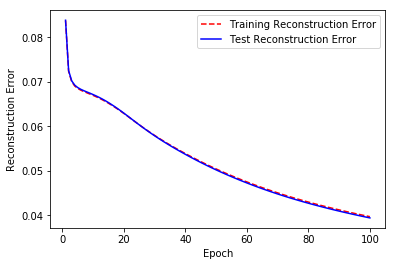

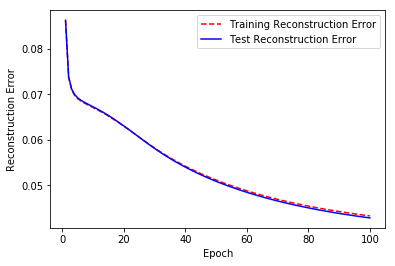

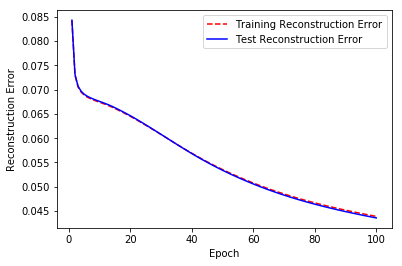

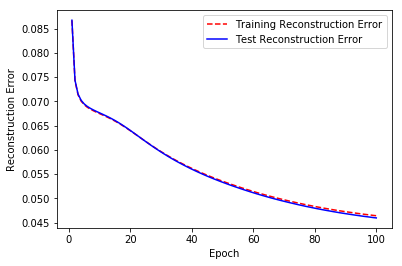

In [24]:
# Now that the models are trained, we want to run through the testing data with no added noise and compare the loss

loss1 = model_denoise1.loss(model_denoise1(x_test), x_test)
loss2 = model_denoise2.loss(model_denoise2(x_test), x_test)
loss3 = model_denoise3.loss(model_denoise3(x_test), x_test)
loss4 = model_denoise4.loss(model_denoise4(x_test), x_test)

print(f'Rec Err 1 = {loss1:0.4f} : Rec Err 2 = {loss2:0.4f} : Rec Err 3 = {loss3:0.4f} : Rec Err 4 = {loss4:0.4f}')

Plot_Loss_and_WeightRegularization(train_loss_plot_denoise1, test_loss_plot_denoise1, weight_regularization_plot_denoise1)
Plot_Loss_and_WeightRegularization(train_loss_plot_denoise2, test_loss_plot_denoise2, weight_regularization_plot_denoise2)
Plot_Loss_and_WeightRegularization(train_loss_plot_denoise3, test_loss_plot_denoise3, weight_regularization_plot_denoise3)
Plot_Loss_and_WeightRegularization(train_loss_plot_denoise4, test_loss_plot_denoise4, weight_regularization_plot_denoise4)

**As can clearly be seen by the printouts of the loss/reconstruction error, it is monotonically increasing based on the order given in the table. This makes sense since it is increasing in magnitude of the noise being added and so the network should perform slightly worse. It is also worth noting that the difference in loss/reconstruction error is fairly low**

## Question 3 Part 2
Choose one of the denoising autencoders from the previous step. Use the hidden representation to train a model to predict the number present in the image.

In [0]:
def Train_Model_1_Layer_with_Data(model, learning_rate, num_epochs, batch_size, x_train, x_test):
  train_loss_plot     = []
  test_loss_plot      = []
  train_accuracy_plot = []
  test_accuracy_plot  = []
  
  train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train_encoded))
  test_dataset  = tf.data.Dataset.from_tensor_slices((x_test,  y_test_encoded))

  for epoch in range(1, num_epochs + 1):
    train_batches = train_dataset.shuffle(100).batch(batch_size)

    for inp, out in train_batches:
      if learning_rate < 0:
        model.train_step(inp, out) #Accounts for using AdaDelta
      else:
        model.train_step(inp, out, learning_rate)

    train_out = model(x_train)
    test_out  = model(x_test)

    current_train_loss = model.loss(train_out, y_train_encoded)
    current_test_loss  = model.loss(test_out,  y_test_encoded)
    train_accuracy_percent = getAccuracy(y_train, train_out)*100
    test_accuracy_percent  = getAccuracy(y_test, test_out)*100

    print(f'Epoch #{epoch}: Train Loss = {current_train_loss:0.4f} : Test Loss = {current_test_loss:0.4f} : Train Accuracy = {train_accuracy_percent:0.4f}% : Test Accuracy = {test_accuracy_percent:0.4f}%')

    train_loss_plot.append(current_train_loss)
    test_loss_plot.append(current_test_loss)
    train_accuracy_plot.append(train_accuracy_percent)
    test_accuracy_plot.append(test_accuracy_percent)
    
  return (train_loss_plot, test_loss_plot, train_accuracy_plot, test_accuracy_plot)

In [26]:
# I chose to use the first one since it performed best on the test dataset (makes sense since it had the least noise)
x_train_encoded = model_denoise1.encode(x_train)
x_test_encoded = model_denoise1.encode(x_test)

# Initialize the fully connected feed forward network and start training
model_3_2 = Model_1_layer(n_input=64, n_hidden1=20, n_output=10)

learning_rate = 0.8
num_epochs    = 100
batch_size    = 128

train_loss_plot_3_2, test_loss_plot_3_2, train_accuracy_plot_3_2, test_accuracy_plot_3_2 = Train_Model_1_Layer_with_Data(model_3_2, learning_rate, num_epochs, batch_size, x_train_encoded, x_test_encoded)

Epoch #1: Train Loss = 0.0893 : Test Loss = 0.0893 : Train Accuracy = 21.7950% : Test Accuracy = 21.9300%
Epoch #2: Train Loss = 0.0881 : Test Loss = 0.0880 : Train Accuracy = 28.0350% : Test Accuracy = 28.1400%
Epoch #3: Train Loss = 0.0848 : Test Loss = 0.0847 : Train Accuracy = 28.9517% : Test Accuracy = 29.3700%
Epoch #4: Train Loss = 0.0782 : Test Loss = 0.0780 : Train Accuracy = 34.8300% : Test Accuracy = 34.8300%
Epoch #5: Train Loss = 0.0704 : Test Loss = 0.0702 : Train Accuracy = 43.8700% : Test Accuracy = 43.4100%
Epoch #6: Train Loss = 0.0620 : Test Loss = 0.0618 : Train Accuracy = 53.1033% : Test Accuracy = 53.0600%
Epoch #7: Train Loss = 0.0545 : Test Loss = 0.0542 : Train Accuracy = 62.4767% : Test Accuracy = 62.5900%
Epoch #8: Train Loss = 0.0485 : Test Loss = 0.0480 : Train Accuracy = 67.0200% : Test Accuracy = 67.5000%
Epoch #9: Train Loss = 0.0438 : Test Loss = 0.0433 : Train Accuracy = 71.0167% : Test Accuracy = 71.8100%
Epoch #10: Train Loss = 0.0403 : Test Loss = 0

Plot the training and testing accuracy for each epoch during training.

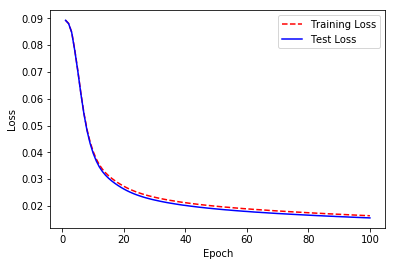

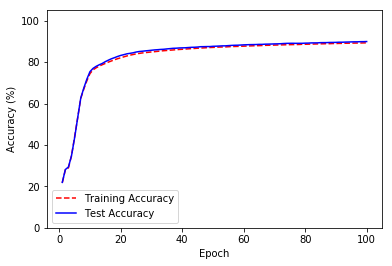

In [27]:
Plot_Loss_and_Accuracy(train_loss_plot_3_2, test_loss_plot_3_2, train_accuracy_plot_3_2, test_accuracy_plot_3_2)

**Very interesting that we can still get 85% from the 64D representation even with just using a single hidden layer classifying network**

